In [17]:
import os, subprocess
import pyspark
print("PySpark version:", pyspark.__version__)

PySpark version: 4.0.1


In [18]:
import os, subprocess
from pyspark.sql import SparkSession

java_home = subprocess.check_output(["/usr/libexec/java_home", "-v", "17"]).decode().strip()
os.environ["JAVA_HOME"] = java_home
os.environ["PATH"] = java_home + "/bin:" + os.environ["PATH"]

spark = (
    SparkSession.builder
    .appName("Taxi-Streaming-Kafka")
    .config("spark.sql.shuffle.partitions", "4")
    .config("spark.sql.ansi.enabled", "false")
    .config(
        "spark.jars.packages",
        "org.apache.spark:spark-sql-kafka-0-10_2.13:4.0.1"
    )
    .getOrCreate()
)

spark

In [19]:
BASE = "/Users/amaiamartingrande/Desktop/WORKSPACE/arquitectura de datos/trabajo_final"

from pyspark.sql.functions import col

lookup_path = f"{BASE}/data/raw/taxi_zone_lookup.csv"

df_zones = (spark.read
    .option("header", True)
    .csv(lookup_path)
)

# Aseguramos mismo tipo que PULocationID (int)
df_zones = df_zones.withColumn("LocationID_int", col("LocationID").cast("int"))

print("Ejemplo de zonas:")
df_zones.select("LocationID_int", "Borough", "Zone").show(5)

Ejemplo de zonas:
+--------------+-------------+--------------------+
|LocationID_int|      Borough|                Zone|
+--------------+-------------+--------------------+
|             1|          EWR|      Newark Airport|
|             2|       Queens|         Jamaica Bay|
|             3|        Bronx|Allerton/Pelham G...|
|             4|    Manhattan|       Alphabet City|
|             5|Staten Island|       Arden Heights|
+--------------+-------------+--------------------+
only showing top 5 rows


In [ ]:
df_kafka = (spark.readStream
    .format("kafka")
    .option("kafka.bootstrap.servers", "localhost:9092")
    .option("subscribe", "taxi_trips")
    .option("startingOffsets", "latest")
    .load()
)

df_kafka.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



-------------------------------------------
Batch: 35
-------------------------------------------
+--------------------------+---------------+-------------+-----------+----------+------------+-------------+-----------------------+--------------------------+
|pickup_datetime           |passenger_count|trip_distance|fare_amount|tip_amount|PULocationID|Borough      |Zone                   |pickup_ts                 |
+--------------------------+---------------+-------------+-----------+----------+------------+-------------+-----------------------+--------------------------+
|2025-12-04T21:47:45.104983|4              |4.03         |14.92      |14.8      |11          |Brooklyn     |Bath Beach             |2025-12-04 21:47:45.104983|
|2025-12-04T21:47:45.105233|1              |11.57        |4.82       |7.99      |116         |Manhattan    |Hamilton Heights       |2025-12-04 21:47:45.105233|
|2025-12-04T21:47:45.105510|1              |8.14         |29.27      |4.33      |50          |Manhatta

In [28]:
from pyspark.sql.functions import col, from_json, to_timestamp
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

schema = StructType([
    StructField("pickup_datetime", StringType()),
    StructField("passenger_count", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("fare_amount", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("PULocationID", IntegerType())
])

df_stream = (df_kafka
    .select(from_json(col("value").cast("string"), schema).alias("j"))
    .select("j.*")
    .withColumn(
        "pickup_ts",
        to_timestamp(col("pickup_datetime"), "yyyy-MM-dd'T'HH:mm:ss.SSSSSS")
    )
)
df_stream_zones = (
    df_stream.join(
        df_zones,
        df_stream.PULocationID == df_zones.LocationID_int,
        "left"
    )
    .drop("LocationID_int")  # ya no nos hace falta
)

# Para comprobar que funciona:
debug_query = (df_stream_zones
    .select(
        "pickup_datetime",
        "passenger_count",
        "trip_distance",
        "fare_amount",
        "tip_amount",
        "PULocationID",
        "Borough",
        "Zone",
        "pickup_ts"
    )
    .writeStream
    .format("console")
    .outputMode("append")
    .option("truncate", "false")
    .trigger(processingTime="5 seconds")
    .start()
)

25/12/04 22:47:57 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /private/var/folders/fj/0grtbsx93wv1w4ln5t90_nph0000gn/T/temporary-c2a349c3-0de4-4c5c-b016-f34a5837a9e2. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/12/04 22:47:57 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+---------------+---------------+-------------+-----------+----------+------------+-------+----+---------+
|pickup_datetime|passenger_count|trip_distance|fare_amount|tip_amount|PULocationID|Borough|Zone|pickup_ts|
+---------------+---------------+-------------+-----------+----------+------------+-------+----+---------+
+---------------+---------------+-------------+-----------+----------+------------+-------+----+---------+

-------------------------------------------
Batch: 37
-------------------------------------------
-------------------------------------------
Batch: 1
-------------------------------------------
+--------------------------+---------------+-------------+-----------+----------+------------+-------------+-----------------------+--------------------------+
|pickup_datetime           |passenger_count|trip_distance|fare_amount|tip_amount|PULocationID|Borough      |Zone       

In [26]:
debug_query.stop()

25/12/04 22:47:19 WARN DAGScheduler: Failed to cancel job group 4f4857f1-8322-4c56-8300-4d5b5e5ce4d4. Cannot find active jobs for it.
25/12/04 22:47:19 WARN DAGScheduler: Failed to cancel job group 4f4857f1-8322-4c56-8300-4d5b5e5ce4d4. Cannot find active jobs for it.


In [ ]:
from pyspark.sql.functions import window, avg, count, sum as _sum, col

kpi_live_now = (df_stream_zones
    .filter(col("pickup_ts").isNotNull())
    .groupBy(
        window(col("pickup_ts"), "10 seconds"),
        col("Borough")
    )
    .agg(
        count("*").alias("n_trips"),
        avg("trip_distance").alias("avg_distance"),
        avg("fare_amount").alias("avg_fare"),
        _sum("tip_amount").alias("total_tips")
    )
)

-------------------------------------------
Batch: 15
-------------------------------------------
-------------------------------------------
Batch: 2
-------------------------------------------
+--------------------------+---------------+-------------+-----------+----------+------------+-------------+-----------------------+--------------------------+
|pickup_datetime           |passenger_count|trip_distance|fare_amount|tip_amount|PULocationID|Borough      |Zone                   |pickup_ts                 |
+--------------------------+---------------+-------------+-----------+----------+------------+-------------+-----------------------+--------------------------+
|2025-12-04T21:45:35.233504|4              |9.63         |49.43      |4.1       |161         |Manhattan    |Midtown Center         |2025-12-04 21:45:35.233504|
|2025-12-04T21:45:35.234046|4              |2.99         |11.75      |4.99      |162         |Manhattan    |Midtown East           |2025-12-04 21:45:35.234046|
|2025

In [23]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_kpi(batch_df, batch_id):
    # batch_df es un DataFrame de Spark con window, Borough, n_trips, etc.
    pdf = batch_df.toPandas()

    if pdf.empty:
        return

    # Ordenamos por nº de viajes
    pdf = pdf.sort_values("n_trips", ascending=False)

    # Limpiar salida anterior para que se vea como animación
    clear_output(wait=True)

    plt.figure(figsize=(8, 5))
    plt.bar(pdf["Borough"], pdf["n_trips"])
    plt.title(f"Viajes por Borough (batch {batch_id})")
    plt.xlabel("Borough")
    plt.ylabel("Número de viajes en la ventana")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

-------------------------------------------
Batch: 17
-------------------------------------------
-------------------------------------------
Batch: 4
-------------------------------------------
+--------------------------+---------------+-------------+-----------+----------+------------+-------------+-----------------------+--------------------------+
|pickup_datetime           |passenger_count|trip_distance|fare_amount|tip_amount|PULocationID|Borough      |Zone                   |pickup_ts                 |
+--------------------------+---------------+-------------+-----------+----------+------------+-------------+-----------------------+--------------------------+
|2025-12-04T21:45:45.099839|4              |8.96         |35.41      |2.38      |5           |Staten Island|Arden Heights          |2025-12-04 21:45:45.099839|
|2025-12-04T21:45:45.100412|2              |2.4          |21.27      |13.06     |3           |Bronx        |Allerton/Pelham Gardens|2025-12-04 21:45:45.100412|
|2025

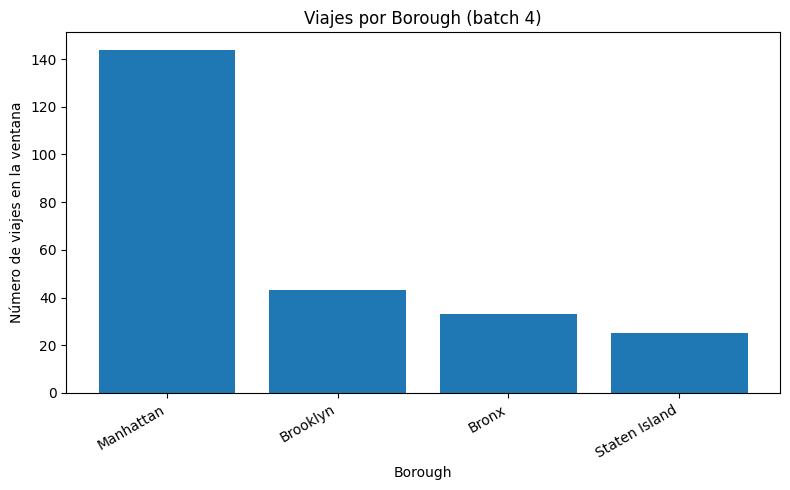

In [ ]:
query_now = (kpi_live_now.writeStream
    .outputMode("complete")
    .foreachBatch(plot_kpi)
    .trigger(processingTime="5 seconds")
    .start()
)

In [25]:
query_now.stop()

25/12/04 22:47:14 WARN DAGScheduler: Failed to cancel job group a44fa3ad-b053-472c-b7ed-f38f42dfcd0e. Cannot find active jobs for it.
25/12/04 22:47:14 WARN DAGScheduler: Failed to cancel job group a44fa3ad-b053-472c-b7ed-f38f42dfcd0e. Cannot find active jobs for it.
